In [121]:
# https://www.tensorflow.org/decision_forests/tutorials/beginner_colab
# https://www.tensorflow.org/decision_forests/tutorials/predict_colab
# https://www.tensorflow.org/decision_forests/tutorials/advanced_colab 

from google.cloud import bigquery

import pandas as pd
import numpy as np

import math
import os

import tensorflow as tf
print(tf.__version__)


#https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall
#https://developers.google.com/machine-learning/crash-course/classification/accuracy

2.12.0


In [122]:
#pip install tensorflow_decision_forests --upgrade --user
import tensorflow_decision_forests as tfdf
print(tfdf.__version__)

1.4.0


# Variable to Configuration

In [123]:
model_tree_type=1# 1= xgboost  2=random forest
option_cate_feature=1 # the best formance    # 1=numberice hour 2. range hour
hyperparameter_template=False

#labelCol='label_multi_severity'
labelCol='label_binary_severity'

#Others are more proper than Accuracy in this case AUC,Recall,F1  (F1 provide  since tensorflow 1.13

model_prefix="demo2"
bucket_name="gs://demo2-tf-incident-pongthorn"

In [124]:
projectId='pongthorn'
dataset_id='SMartML'

train_name='train2_incident'
test_name='test2_incident'


train_table_id=f"{projectId}.{dataset_id}.{train_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"
print(f"train-ds = {train_table_id}")
print(f"test-ds = {test_tabel_id}")

train-ds = pongthorn.SMartML.train2_incident
test-ds = pongthorn.SMartML.test2_incident


In [125]:
if  labelCol=='label_multi_severity':
    if model_tree_type==1:
        _model=f'{model_prefix}_multi_gbt_tf_model'
    else:
         _model=f'{model_prefix}_multi_rf_tf__model'
else:
    if model_tree_type==1:
        _model=f'{model_prefix}_binary_gbt_tf_model'
    else:
         _model=f'{model_prefix}_binary_rf_tf_model'

if option_cate_feature==1:
    
    cateCols=['sla','product_type','brand','service_type','incident_type']
    numbericCols=['open_to_close_hour']
    if labelCol=='label_multi_severity':
     unusedCols=['id','severity_id','severity_name','range_open_to_close_hour','label_binary_severity']
    else:
      unusedCols=['id','severity_id','severity_name','range_open_to_close_hour','label_multi_severity']  
else:
    # cateCols=['sla','product_type','brand','service_type','incident_type','range_open_to_close_hour','range_response_to_resolved_hour']
    cateCols=['sla','product_type','brand','service_type','incident_type','range_open_to_close_hour']
    numbericCols=[]
    #unusedCols=['id','severity_id','severity_name','label_binary_severity','open_to_close_hour','response_to_resolved_hour']
    if labelCol=='label_multi_severity':
     unusedCols=['id','severity_id','severity_name','open_to_close_hour','label_binary_severity']
    else:
     unusedCols=['id','severity_id','severity_name','open_to_close_hour','label_multi_severity']   
    
    _model=f"{_model}_range_hour"
 


print(f"CateCols : {cateCols}")
print(f"NumbericCols : {numbericCols}")
print(f"UnusedCols : {unusedCols}")

model_gs_path=f"{bucket_name}/{_model}"
print(model_gs_path)
#model_local_path=_model

CateCols : ['sla', 'product_type', 'brand', 'service_type', 'incident_type']
NumbericCols : ['open_to_close_hour']
UnusedCols : ['id', 'severity_id', 'severity_name', 'range_open_to_close_hour', 'label_multi_severity']
gs://demo2-tf-incident-pongthorn/demo2_binary_gbt_tf_model


# Load & Prepare Data

In [126]:
def load_ml_data(data_path):
 df=pd.read_csv(data_path)
 df =df.drop(columns=unusedCols)
 
 return df

def load_data_bq(sql:str):
 
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 df =df.drop(columns=unusedCols)
 df[labelCol]=df[labelCol].astype('int64') 
 df=df[[labelCol]+cateCols+numbericCols]   
  
 return df

In [127]:
client = bigquery.Client(project=projectId)

train=load_data_bq(f"SELECT * FROM {train_table_id}")
test=load_data_bq(f"SELECT * FROM {test_tabel_id}")

print(train.info())

print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252 entries, 0 to 3251
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   label_binary_severity  3252 non-null   int64  
 1   sla                    3252 non-null   object 
 2   product_type           3252 non-null   object 
 3   brand                  3252 non-null   object 
 4   service_type           3252 non-null   object 
 5   incident_type          3252 non-null   object 
 6   open_to_close_hour     3252 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 178.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   label_binary_severity  814 non-null    int64  
 1   sla                    814 non-null    object 
 2   product_type           814 non-null    o

# Explore & Visualize Target Class Label

In [128]:
classes_train = list(train[labelCol].unique())
classes_test = list(test[labelCol].unique())

set_classes=set(classes_train) & set(classes_test)
classes=list(set_classes)
print(classes)



[0, 1]


1(Critical) in Train=1717 and  1(Critical) in Test=414
Train: Ratio of 1(Critical) to AllLabels is 0.53
Test: Ratio of 1(Critical) to AllLabels is 0.51


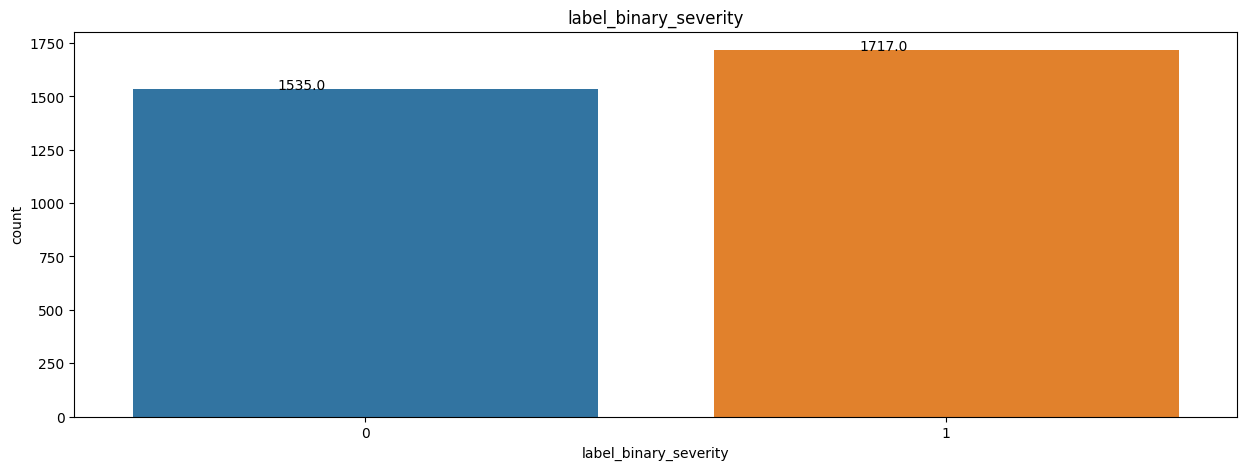

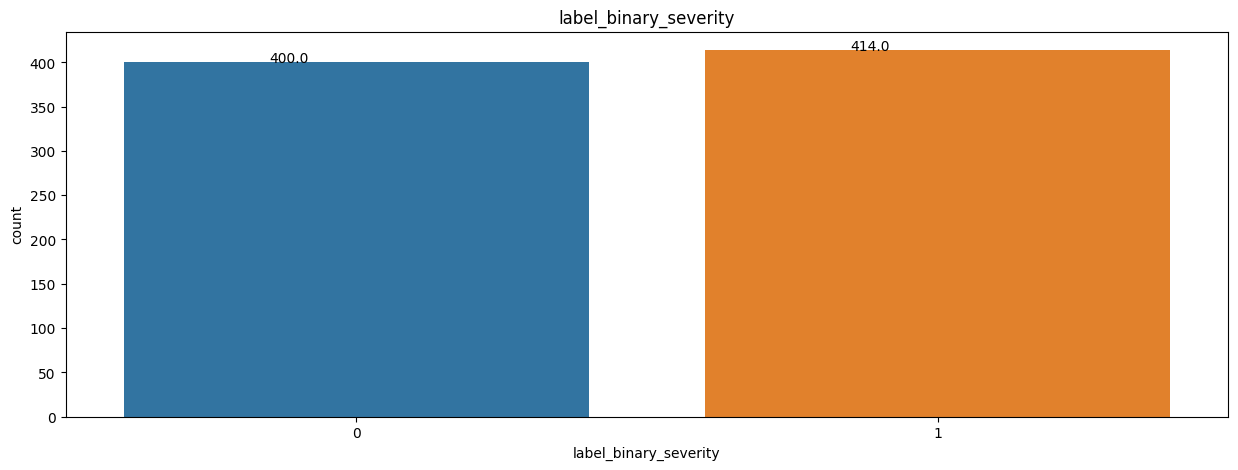

In [129]:
no_1_train=len(train.query(f"{labelCol}==1"))
no_1_test=len(test.query(f"{labelCol}==1"))
print(f"1(Critical) in Train={no_1_train} and  1(Critical) in Test={no_1_test}")

print(f"Train: Ratio of 1(Critical) to AllLabels is {round(no_1_train/len(train),2)}")
print(f"Test: Ratio of 1(Critical) to AllLabels is {round(no_1_test/len(test),2)}")

import seaborn as sns
import matplotlib.pyplot  as plt
def plot_label(df_):

    fig , ax = plt.subplots(figsize=(15,5))
    ax =sns.countplot(x=labelCol, data=df_,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(labelCol)
    plt.show()
        
plot_label(train)
plot_label(test)

In [130]:
train.tail(5)

,label_binary_severity,sla,product_type,brand,service_type,incident_type,open_to_close_hour
3247,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,308.166667
3248,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,Configuration Change,4.066667
3249,0,24x7 4Hrs Response Time,Security,Trend Micro,Request,General Incident,0.333333
3250,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,Configuration Change,5.516667
3251,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,21.333333


In [131]:
test.tail()

,label_binary_severity,sla,product_type,brand,service_type,incident_type,open_to_close_hour
809,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,76.283333
810,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,114.066667
811,0,24x7 4Hrs Response Time,Software,Trend Micro,Incident,General Incident,456.600000
812,0,24x7 4Hrs Response Time,Software,Trend Micro,Incident,General Incident,142.883333
813,0,24x7 4Hrs Response Time,Software,Trend Micro,Incident,Software,54.000000


# Convert dataframe to tensorflow dataset

In [132]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=labelCol)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label=labelCol)

# Build Model

In [133]:
# Specify the model.
if model_tree_type==1:
    print(f"GradientBoostedTreesModel and HyperparameterTemplate={hyperparameter_template}")
    #https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/GradientBoostedTreesModel
    if hyperparameter_template:
     model=tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
    else:
     model=tfdf.keras.GradientBoostedTreesModel()
else:
    print(f"RandomForestModel and HyperparameterTemplate={hyperparameter_template}")
    if hyperparameter_template:
     model = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")
    else:
       model = tfdf.keras.RandomForestModel()  
 
print("List hyperparameter")   
print(tfdf.keras.GradientBoostedTreesModel.predefined_hyperparameters())


GradientBoostedTreesModel and HyperparameterTemplate=False
Use /var/tmp/tmpco8kes6k as temporary training directory
List hyperparameter
[HyperParameterTemplate(name='better_default', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL'}, description='A configuration that is generally better than the default parameters without being more expensive.'), HyperParameterTemplate(name='benchmark_rank1', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}, description='Top ranking hyper-parameters on our benchmark slightly modified to run in reasonable time.')]


[WARNING 24-01-06 13:14:35.7948 UTC gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-06 13:14:35.7960 UTC gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-06 13:14:35.7965 UTC gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


In [134]:
model.fit(x=train_ds)

Reading training dataset...


2024-01-06 13:14:35.831140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [3252]
	 [[{{node Placeholder/_5}}]]


Training dataset read in 0:00:00.190777. Found 3252 examples.
Training model...
Model trained in 0:00:00.187172
Compiling model...


[INFO 24-01-06 13:14:36.1960 UTC kernel.cc:1243] Loading model from path /var/tmp/tmpco8kes6k/model/ with prefix 4169b1565f0942d7
[INFO 24-01-06 13:14:36.2037 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-01-06 13:14:36.2043 UTC kernel.cc:1075] Use fast generic engine
2024-01-06 13:14:36.215752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [3252]
	 [[{{node Placeholder/_4}}]]


Model compiled.


In [135]:
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC
# https://keras.io/api/metrics/classification_metrics/
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall
rc_pc_thresholds=0.4

myMetrics=[
           # tf.keras.metrics.BinaryAccuracy(threshold=rc_pc_thresholds)
           tf.keras.metrics.BinaryAccuracy()
           ,tf.keras.metrics.AUC()
           ,tf.keras.metrics.Precision(thresholds=rc_pc_thresholds)
           ,tf.keras.metrics.Recall(thresholds=rc_pc_thresholds)]

model.compile(metrics=myMetrics)
evaluation = model.evaluate(test_ds, return_dict=True)
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

2024-01-06 13:14:36.656537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype int64 and shape [814]
	 [[{{node Placeholder/_6}}]]


1/1 [==============================] - 0s 281ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8268 - auc_5: 0.9007 - precision_5: 0.7872 - recall_5: 0.8937
loss: 0.0000
binary_accuracy: 0.8268
auc_5: 0.9007
precision_5: 0.7872
recall_5: 0.8937


# Inspect and debug decision forest models
## Model structure and feature importance

In [136]:
inspector=model.make_inspector()

print("Model type:", inspector.model_type())
print("Number of trees:", inspector.num_trees())
print("Objective:", inspector.objective())
print("Input features:", inspector.features())

#[field for field in dir(inspector) if not field.startswith("_")]
# SUM_SCORE ,NUM_AS_ROOT

Model type: GRADIENT_BOOSTED_TREES
Number of trees: 39
Objective: Classification(label=__LABEL, class=None, num_classes=2)
Input features: ["brand" (4; #1), "incident_type" (4; #2), "open_to_close_hour" (1; #3), "product_type" (4; #4), "service_type" (4; #5), "sla" (4; #6)]


In [137]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_NODES
	 NUM_AS_ROOT
	 SUM_SCORE


# Model Self Evaluation

In [138]:
inspector.evaluation()

Evaluation(num_examples=None, accuracy=0.8242811560630798, loss=0.7957839369773865, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

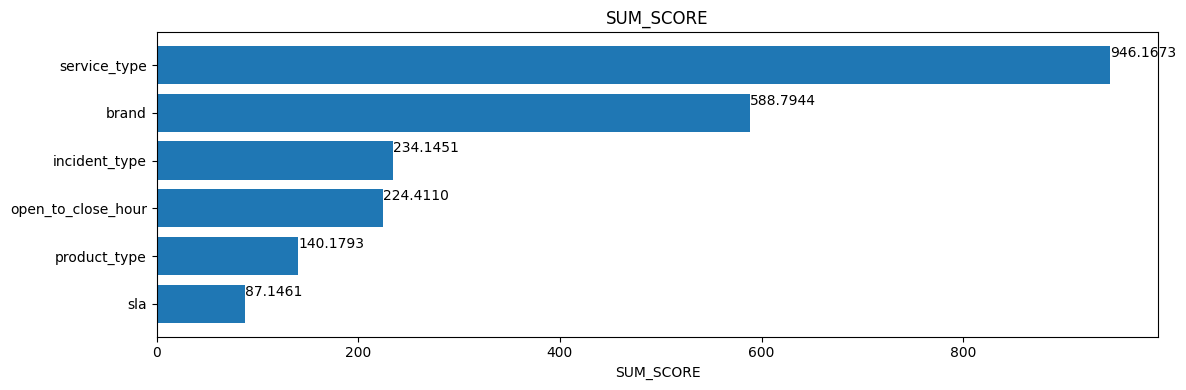

In [139]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "SUM_SCORE"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title(variable_importance_metric)
plt.tight_layout()
plt.show()

# Plot the model

In [140]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=4)

# Examine log training

In [141]:
logs = inspector.training_logs()


# Plotting the training logs

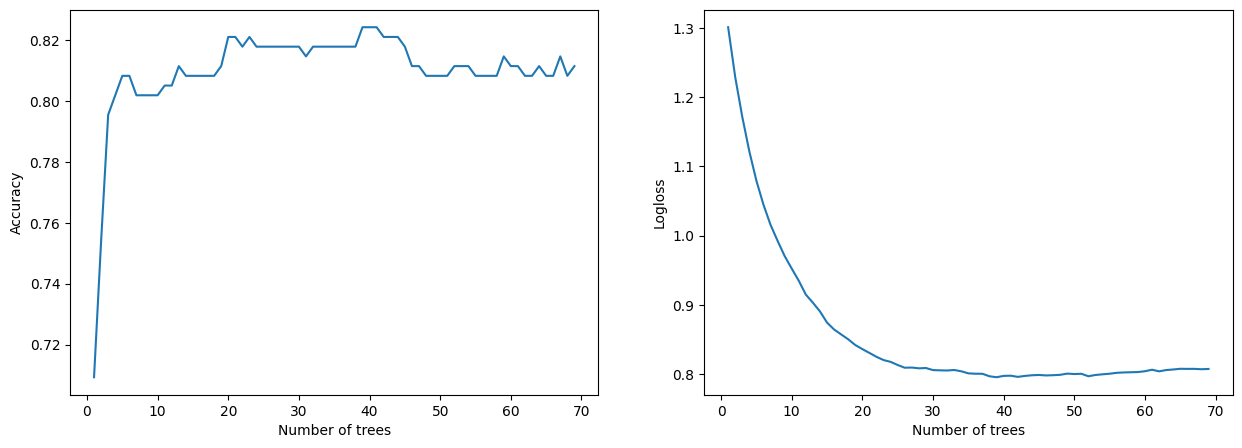

In [142]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss")

plt.show()

In [22]:

#model.save(model_gs_path)

INFO:tensorflow:Assets written to: gs://demo2-tf-incident-pongthorn/demo2_binary_gbt_tf_model/assets


INFO:tensorflow:Assets written to: gs://demo2-tf-incident-pongthorn/demo2_binary_gbt_tf_model/assets


In [23]:
# To Tensorbord
#inspector.export_to_tensorboard(f"./tb_logs/{_model}")